# Notebook to evaluate model entropy

In [293]:
from transformers import BertTokenizer, GPT2Tokenizer,  GPT2LMHeadModel, BertForMaskedLM
import scipy
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import glob
from tqdm import tqdm

In [6]:
from GPT2.tokenizer import tokenize
from LSTM.tokenizer import unk_transform
#from LSTM.model import LSTMExtractor
from LSTM.data import Dictionary

In [7]:
from GPT2 import utils as utils_gpt2
from BERT import utils as utils_bert
from ROBERTA import utils as utils_roberta


### Functions

In [4]:
def eval_output(out):
    result = np.sum([entropy(scipy.special.softmax(out[ax])) for ax in range(out.shape[0])]) 
    return result

def entropy(pk):
    pk = pk
    entropy = -np.sum(pk * np.log2(pk), axis=0)
    return entropy 

### Model instanciation

In [32]:
model_base = GPT2LMHeadModel.from_pretrained('gpt2')
t_base = GPT2Tokenizer.from_pretrained('gpt2')

In [33]:
model_medium = GPT2LMHeadModel.from_pretrained('gpt2-medium')
t_medium = GPT2Tokenizer.from_pretrained('gpt2-medium')

In [5]:
model_bert = BertForMaskedLM.from_pretrained('bert-base-cased')
t_bert = BertTokenizer.from_pretrained('bert-base-cased') 

In [6]:
model_roberta = RobertaForMaskedLM.from_pretrained('roberta-base')
t_roberta = RobertaTokenizer.from_pretrained('roberta-base') 

In [20]:
model_lstm = LSTMExtractor(...)

NameError: name 'LSTMExtractor' is not defined

In [26]:
data = pd.read_csv('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/english/LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english/activations_run1.csv')
lstm_result = data['entropy']

### Data retrieval 

In [2]:
language = 'english'

In [3]:
template = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/text_english_run*.txt' # path to text input  
#template = '/USers/alexpsq/Code/Parietal/data/text_english_run*.txt'
#template = '/USers/alexpsq/Code/Parietal/data/an_african_millionaire_run*.txt'
#template = '/USers/alexpsq/Code/Parietal/data/arsene_lupin_run*.txt'

In [4]:
paths = sorted(glob.glob(template))

In [8]:
iterator_list = [tokenize(path, language, train=False) for path in paths]

100%|██████████| 207/207 [00:00<00:00, 200281.64it/s]


In [70]:
vocab_path = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/lstm_training'
#vocab_path = '/Users/alexpsq/Code/data/'
vocab = Dictionary(vocab_path, language)

Tokenizing...


AssertionError: 

In [ ]:
iterator_list_lstm = [[unk_transform(word, vocab) for item in iterator_ for word in item.strip().split(' ')] for iterator_ in iterator_list]


In [47]:
result = []  
out_lstm = []
index=0

for line in iterator_list[0]:  
    result.append(len([word for word in line.strip().split(' ')])) 

In [48]:
for i in result:
    out_lstm.append(np.sum(lstm_result[index:index+i]))
    index+=i 

In [49]:
out_lstm

[183.65975710354851,
 71.44852300354914,
 45.72299470354632,
 113.50458310355049,
 128.90891215854867,
 209.65525910354947,
 34.35419340354517,
 144.48438960354974,
 97.09641070315439,
 60.37677470355296,
 67.54911890354934,
 125.13147190355014,
 51.173383903549976,
 260.3222846035489,
 98.06378363354852,
 120.75370870354918,
 153.3907406035488,
 95.91059720354967,
 67.33133240354964,
 84.52844240355043,
 67.81662720354971,
 80.23262440355009,
 107.11179380354835,
 53.95107700354885,
 46.710130303550415,
 51.326691603549705,
 232.72192330355054,
 91.490372303549,
 86.80414060354953,
 133.81081290355039,
 40.02907210354929,
 79.50843020354867,
 84.53273950355037,
 155.84227120354927,
 42.52000280354969,
 196.79355210355178,
 63.94577170354957,
 71.8092554035494,
 136.23538600354962,
 105.99230013354902,
 117.12406700355002,
 38.5245366,
 37.45868350346743,
 22.73666750327454,
 40.82155830344858,
 81.45440640355046,
 29.091671403550965,
 46.596370403549955,
 103.5331177035493,
 95.134956

### Evaluation

In [42]:
results = []

In [43]:
def eval_output(out):
    result = np.sum([entropy(scipy.special.softmax(out[ax])) for ax in range(out.shape[0])]) 
    return result

def entropy(pk):
    pk = pk
    entropy = -np.sum(pk * np.log2(pk), axis=0)
    return entropy 

In [17]:

result = []
batches, indexes = utils_gpt2.batchify_per_sentence_with_context(iterator_list[0], 1, 15, 'gpt2', max_length=512)
for index, batch in enumerate(batches):
    batch = batch.strip()
    tokenized_text = t_base.tokenize(batch, add_prefix_space=True)
    inputs_ids = torch.tensor([t_base.convert_tokens_to_ids(tokenized_text)])
    attention_mask = torch.tensor([[1 for x in tokenized_text]])
    out_gpt2_base = model_base(inputs_ids, attention_mask=attention_mask)
    mapping = utils_gpt2.match_tokenized_to_untokenized(tokenized_text, batch)

    out = out_gpt2_base[0].detach().squeeze(0).numpy()
    key = None
    new_activations = []
    for key_, value in mapping.items(): 
        if value[0] == indexes[index][0]:
            key = key_
    #print(indexes[index][0], mapping)
    for word_index in range(key, len(mapping.keys())):
        word_activation = []
        word_activation.append([out[index, :] for index in mapping[word_index]])
        word_activation = np.vstack(word_activation)
        new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
    activations = np.vstack(new_activations)
    result.append(eval_output(activations))
print(result)

[1479.7416, 81.449234, 133.16344, 84.96507, 65.91492, 57.852043, 67.326385, 67.71767, 107.38642, 57.373596, 45.209236, 48.960426, 194.10556, 86.80297, 85.67359, 138.64224, 36.772038, 80.569664, 76.45224, 144.53545, 40.44752, 176.63167, 53.160664, 63.024975, 121.399635, 98.385025, 98.946335, 35.67877, 41.66576, 32.041798, 35.979294, 67.63603, 25.65775, 44.13664, 96.6409, 80.69574, 94.12051, 41.170517, 224.02808, 66.01508, 75.64002, 148.27258, 115.84273, 100.31509, 95.7048, 25.196476, 78.75001, 161.28549, 213.25603, 44.87957, 31.980438, 146.24057, 59.030235, 81.71396, 9.538782, 70.57346, 84.76148, 49.91638, 32.467304, 24.687328, 24.578554, 46.58152, 50.78563, 27.506622, 105.17947, 76.638115, 25.125643, 169.71748, 67.78848, 196.56427, 57.977867, 139.05779, 68.33978, 29.470459, 86.83928, 38.392086, 66.54461, 74.31881, 10.809681, 41.35556, 64.11928, 54.646378, 96.48307, 87.59054, 240.96822, 47.792496, 15.6032505, 30.054953, 44.417683, 78.10411, 35.53222, 33.70642, 47.416634, 19.873497, 19.4

In [44]:
all_results = None

In [58]:
step = 7
maxi = -100
for run in range(len(iterator_list)):
    for index, batch in enumerate(iterator_list[run]):
        stop = min(len(iterator_list[run]), step+index)
        m = len(t_roberta.tokenize(' '.join(iterator_list[run][index:stop]), add_prefix_space=True)) #, add_prefix_space=True
        if m>maxi:
            maxi = m
            print('-',m)

- 224
- 230
- 236
- 244
- 260
- 294
- 398
- 440


In [80]:
all_results_gpt2

,index,GTP2_pre-0_1_post-0,GTP2_pre-1_1_post-0,GTP2_pre-2_1_post-0,GTP2_pre-5_1_post-0,GTP2_pre-7_1_post-0,GTP2_pre-10_1_post-0,GTP2_pre-12_1_post-0
0,0,55305.641523,51445.874406,50414.564680,48625.503493,48031.813206,47534.147072,47357.565907
1,0,68890.231043,63405.695988,62086.252079,59872.646417,58994.405281,58264.866754,58077.767081
2,0,74351.022091,68194.730121,66711.999184,63931.046370,63183.442468,62440.122370,62244.198508
3,0,35295.290989,32401.915530,31745.936753,30883.919034,30448.607148,30130.958165,30016.657846
4,0,58089.241796,53058.819623,51829.997030,49282.020134,48424.388550,47629.696575,47535.560178
5,0,51654.255611,48006.428402,47160.212482,45713.254002,45065.910264,44379.439433,44269.211005
6,0,53868.893536,50394.993421,49462.264472,47878.138650,47451.430774,47028.413953,46915.132445
7,0,69418.432489,64698.616269,62976.528176,58855.473420,57435.172002,56061.377932,55756.775476
8,0,53087.950281,49240.586370,48073.361211,46022.604879,45174.001082,44382.391432,44235.580158
9,0,47316.834970,43863.376293,43002.255971,41562.700187,41023.895491,40561.574821,40478.453667


In [74]:
names = ['GTP2_pre-0_1_post-0', 
         'GTP2_pre-1_1_post-0', 
         'GTP2_pre-2_1_post-0', 
         'GTP2_pre-5_1_post-0', 
         'GTP2_pre-7_1_post-0', 
         'GTP2_pre-10_1_post-0', 
         'GTP2_pre-11_1_post-0'
        ]
pre_context = [0, 1, 2, 5, 7, 10, 11]
post_context = [0, 0, 0, 0, 0, 0, 0]

all_results_gpt2 = None
for run in range(len(iterator_list)):
    results_gpt2 = None
    for i, name in enumerate(names):
        result_gpt2 = []
        batches, indexes = utils_gpt2.batchify_per_sentence_with_context(iterator_list[run], 1, pre_context[i], 'gpt2', max_length=512)
        for index, batch in enumerate(batches):
            batch = batch.strip()
            tokenized_text = t_base.tokenize(batch, add_prefix_space=True)
            inputs_ids = torch.tensor([t_base.convert_tokens_to_ids(tokenized_text)])
            attention_mask = torch.tensor([[1 for x in tokenized_text]])
            out_gpt2_base = model_base(inputs_ids, attention_mask=attention_mask)
            mapping = utils_gpt2.match_tokenized_to_untokenized(tokenized_text, batch)

            out = out_gpt2_base[0].detach().squeeze(0).numpy()
            key = None
            new_activations = []
            for key_, value in mapping.items(): 
                if value[0] == indexes[index][0]:
                    key = key_
            #print(indexes[index][0], mapping)
            for word_index in range(key, len(mapping.keys())):
                word_activation = []
                word_activation.append([out[index, :] for index in mapping[word_index]])
                word_activation = np.vstack(word_activation)
                new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
            activations = np.vstack(new_activations)
            result_gpt2.append(eval_output(activations))
        result_gpt2 = pd.DataFrame([sum(result_gpt2)], columns=[name])
        results_gpt2 = result_gpt2 if results_gpt2 is None else pd.concat([results_gpt2, result_gpt2], axis=1)
    all_results_gpt2 = results_gpt2 if all_results_gpt2 is None else pd.concat([all_results_gpt2, results_gpt2], axis=0)
    

KeyboardInterrupt: 

In [55]:
all_results_bert.reset_index(inplace=True)

In [51]:
names = ['BERT_pre-0_1_post-0', 
         'BERT_pre-1_1_post-0', 
         'BERT_pre-2_1_post-0', 
         'BERT_pre-5_1_post-0', 
         'BERT_pre-7_1_post-0', 
         #'BERT_pre-10_1_post-0', 
         #'BERT_pre-11_1_post-0', 
         #'BERT_pre-15_1_post-0',
         #'BERT_pre-20_1_post-0',
         #'BERT_pre-10_1_post-1',
         #'BERT_pre-10_1_post-2',
         #'BERT_pre-10_1_post-5',
         #'BERT_pre-10_1_post-7',
         #'BERT_pre-10_1_post-10',
        ]
pre_context = [0, 1, 2, 5, 7, 10, 11, 15, 20, 10, 10, 10, 10, 10]
post_context = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 5, 7, 10]
all_results_bert = None
for run in range(len(iterator_list)):
    results_bert = None
    for i, name in enumerate(names):
        result_bert = []
        batches, indexes = utils_bert.batchify_per_sentence_with_pre_and_post_context(iterator_list[run], 1, pre_context[i], post_context[i], 'bert-base-cased', max_length=512)
        for index, batch in enumerate(batches):
            batch = '[CLS] ' + batch.strip() + ' [SEP]'
            tokenized_text = t_bert.wordpiece_tokenizer.tokenize(batch)
            inputs_ids = torch.tensor([t_bert.convert_tokens_to_ids(tokenized_text)])
            attention_mask = torch.tensor([[1 for x in tokenized_text]])
            out_bert = model_bert(inputs_ids, attention_mask=attention_mask)
            mapping = utils_bert.match_tokenized_to_untokenized(tokenized_text, batch)

            out = out_bert[0].detach().squeeze(0).numpy()
            new_activations = []

            key_start = None
            key_stop = None
            for key_, value in mapping.items(): 
                if (value[0] - 1) == (indexes[index][0]): #because we added [CLS] token at the beginning
                    key_start = key_
            for key_, value in mapping.items(): 
                if value[-1] == (indexes[index][1]): #because we added [CLS] token at the beginning
                    key_stop = key_
            for word_index in range(key_start, key_stop + 1): # len(mapping.keys()) - 1
                word_activation = []
                word_activation.append([out[index, :] for index in mapping[word_index]])
                word_activation = np.vstack(word_activation)
                new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
            activations = np.vstack(new_activations)
            result_bert.append(eval_output(activations))
        result_bert = pd.DataFrame([sum(result_bert)], columns=[name])
        results_bert = result_bert if results_bert is None else pd.concat([results_bert, result_bert], axis=1)
    all_results_bert = results_bert if all_results_bert is None else pd.concat([all_results_bert, results_bert], axis=0)


ValueError: Too many context sentence. You reach 444 tokens only with context.

In [63]:
all_results_roberta.reset_index(inplace=True)

In [59]:
names = ['ROBERTA_pre-0_1_post-0', 
         'ROBERTA_pre-1_1_post-0', 
         'ROBERTA_pre-2_1_post-0', 
         'ROBERTA_pre-5_1_post-0', 
         'ROBERTA_pre-7_1_post-0', 
         #'ROBERTA_pre-10_1_post-0', 
         #'ROBERTA_pre-11_1_post-0', 
         #'ROBERTA_pre-15_1_post-0',
         #'ROBERTA_pre-20_1_post-0',
         #'ROBERTA_pre-10_1_post-1',
         #'ROBERTA_pre-10_1_post-2',
         #'ROBERTA_pre-10_1_post-5',
         #'ROBERTA_pre-10_1_post-7',
         #'ROBERTA_pre-10_1_post-10',
        ]
pre_context = [0, 1, 2, 5, 7, 10, 11, 15, 20, 10, 10, 10, 10, 10]
post_context = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 5, 7, 10]
all_results_roberta = None

for run in range(len(iterator_list)):
    results_roberta = None
    for i, name in enumerate(names):
        result_roberta = []
        batches, indexes = utils_roberta.batchify_per_sentence_with_pre_and_post_context(iterator_list[run],  1, pre_context[i], post_context[i], 'roberta-base', max_length=512)
        for index, batch in enumerate(batches):
            batch = '<s> ' + batch.strip() + ' </s>'
            tokenized_text = t_roberta.tokenize(batch, add_prefix_space=True)
            inputs_ids = torch.tensor([t_roberta.convert_tokens_to_ids(tokenized_text)])
            attention_mask = torch.tensor([[1 for x in tokenized_text]])
            out_roberta = model_roberta(inputs_ids, attention_mask=attention_mask)
            mapping = utils_roberta.match_tokenized_to_untokenized(tokenized_text, batch)

            out = out_roberta[0].detach().squeeze(0).numpy()
            new_activations = []
            key_start = None
            key_stop = None
            for key_, value in mapping.items(): 
                if (value[0] - 1) == (indexes[index][0]): #because we added [CLS] token at the beginning
                    key_start = key_
            for key_, value in mapping.items(): 
                if value[-1] == (indexes[index][1]): #because we added [CLS] token at the beginning
                    key_stop = key_
            for word_index in range(key_start, key_stop + 1): # len(mapping.keys()) - 1
                word_activation = []
                word_activation.append([out[index, :] for index in mapping[word_index]])
                word_activation = np.vstack(word_activation)
                new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
            activations = np.vstack(new_activations)
            result_roberta.append(eval_output(activations))
        result_roberta = pd.DataFrame([sum(result_roberta)], columns=[name])
        results_roberta = result_roberta if results_roberta is None else pd.concat([results_roberta, result_roberta], axis=1)
    all_results_roberta = results_roberta if all_results_roberta is None else pd.concat([all_results_roberta, results_roberta], axis=0)


ValueError: Too many context sentence. You reach 417 tokens only with context.

In [18]:
all_results = pd.concat([all_results_bert, all_results_roberta], axis=1)

In [24]:
all_results

,index,BERT_pre-0_1_post-0,BERT_pre-1_1_post-0,BERT_pre-2_1_post-0,BERT_pre-5_1_post-0,BERT_pre-7_1_post-0,BERT_pre-10_1_post-0,BERT_pre-11_1_post-0,ROBERTA_pre-0_1_post-0,ROBERTA_pre-1_1_post-0,ROBERTA_pre-2_1_post-0,ROBERTA_pre-5_1_post-0,ROBERTA_pre-7_1_post-0,ROBERTA_pre-10_1_post-0,ROBERTA_pre-11_1_post-0
0,0,6294.588868,3453.322642,3430.093215,3442.802408,3445.339972,3678.686659,3802.301213,4121.907184,3206.794593,3205.882907,3172.166472,3127.430941,3103.308778,3114.799681
1,0,8730.741971,4918.520709,4864.410397,4757.879644,4729.129413,4665.821555,4687.806476,5957.584522,4686.291108,4687.212632,4613.708926,4447.560117,4256.727442,4224.244672
2,0,9522.571312,5276.963846,5122.758643,4752.497215,4695.997117,4690.013815,4695.546839,6258.860806,4970.707041,5056.936500,4911.600092,4742.087290,4671.251451,4688.070583
3,0,4534.840830,2379.086388,2299.513158,2193.404179,2148.120639,2098.826896,2094.172256,3191.837144,2238.639414,2233.564670,2201.821491,2160.150024,2054.190903,2038.121355
4,0,6517.557376,3242.646690,3262.129565,3235.162692,3258.999545,3319.586287,3328.439776,3964.638425,3000.710851,2989.488373,2855.168382,2829.898611,2822.496642,2827.240877
5,0,6268.839063,3474.662143,3484.355505,3475.472985,3430.721101,3473.053532,3521.652058,4057.638415,3125.833460,3089.799932,3027.954832,3015.536898,2889.284045,2881.294986
6,0,6353.860350,3578.121039,3518.731663,3467.701553,3462.574798,3477.238558,3495.754806,4045.581075,3127.084320,3176.343445,3020.576089,2983.906760,2941.071760,2946.310119
7,0,8701.029636,4994.199975,4718.604970,4213.623018,4085.792272,4063.176710,4066.488015,5845.857102,5166.305257,5102.797955,4485.873462,4184.118473,3886.184406,3886.591952
8,0,6666.253310,3725.233475,3589.817827,3360.846953,3296.990762,3442.207902,3522.877355,4877.350551,4199.298281,4235.989424,3842.446562,3670.600778,3457.276186,3430.045892
9,0,5844.802076,3119.310398,3044.163018,2988.320936,2954.339459,2980.218389,2968.898049,3982.489761,3138.902426,3092.698219,3036.725005,2990.889909,2852.129298,2832.357903


In [ ]:
for col in all_results.columns:
    print(all_results[col])

In [23]:
!pwd

/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/models


In [97]:
all_results.to_csv('perplexity_run9.csv', index=False)

In [6]:
df = []
for index in range(9):
    path = 'perplexity_run{}.csv'.format(index+1)
    df.append(pd.read_csv(path))
results = pd.concat(df, axis=0)
results

,GTP2_pre-0_1_post-0,GTP2_pre-1_1_post-0,GTP2_pre-2_1_post-0,GTP2_pre-5_1_post-0,GTP2_pre-10_1_post-0,GTP2_pre-15_1_post-0,GTP2_pre-20_1_post-0,BERT_pre-0_1_post-0,BERT_pre-1_1_post-0,BERT_pre-2_1_post-0,...,ROBERTA_pre-2_1_post-0,ROBERTA_pre-5_1_post-0,ROBERTA_pre-10_1_post-0,ROBERTA_pre-15_1_post-0,ROBERTA_pre-20_1_post-0,ROBERTA_pre-10_1_post-1,ROBERTA_pre-10_1_post-2,ROBERTA_pre-10_1_post-5,ROBERTA_pre-10_1_post-7,ROBERTA_pre-10_1_post-10
0,12862.889162,12051.681940,11759.912479,11427.471048,10998.547359,10789.830156,10602.872069,1063.102190,420.264434,418.820931,...,271.263524,304.144709,305.522357,288.250395,282.710683,306.883566,312.086597,306.241207,306.912280,317.701272
0,14230.134956,13176.392605,12952.393009,12509.158353,12118.624939,11968.272641,11834.274090,1022.124450,399.866943,405.507616,...,285.454758,276.400742,285.223579,289.686105,294.701153,282.654776,286.425865,306.481945,311.506456,319.727387
0,15900.967472,14790.009586,14695.972878,14446.821256,14138.390575,13930.513450,13814.139940,1441.987063,681.605076,654.336114,...,372.478572,396.581586,392.162695,400.350307,423.020461,384.838514,386.414664,403.147995,410.393751,413.367988
0,15113.656212,13813.267466,13445.379359,12721.217504,12221.506789,12002.882180,11815.444576,1215.212729,645.187130,616.835105,...,410.358541,428.536069,418.231007,434.513322,447.438928,403.154128,408.507958,413.672057,405.466030,413.761305
0,14448.129845,13142.967417,12835.827240,12111.345654,11483.782125,11118.281601,10960.745572,1047.326109,456.320220,431.638367,...,379.969109,409.020718,407.920640,440.182031,451.866981,401.512077,411.661303,435.949454,435.293888,442.732245
0,17246.157990,15696.744569,15287.650419,14361.441486,13653.366058,13384.479657,13214.833519,1411.412894,614.370102,579.581166,...,393.404529,383.862441,412.251764,426.300986,432.466101,395.615902,394.956915,406.388677,404.981423,407.556237
0,17444.283937,15625.288340,15190.177213,13996.251896,13079.823723,12773.562629,12603.911168,1150.835814,489.640269,484.416965,...,408.983461,365.100212,388.728372,427.915712,438.705793,375.983273,377.870725,386.275187,386.871454,396.507425
0,14038.540993,12932.982833,12646.334278,12177.948737,11680.084953,11423.415268,11275.396762,934.536643,356.875287,347.062644,...,277.420008,307.107436,313.220373,334.808677,349.362957,316.038416,321.708656,330.145567,328.998598,330.725181
0,17234.425520,15869.346226,15642.961370,15084.550968,14557.490854,14314.978811,14101.534541,1284.265415,373.734810,361.306577,...,326.654135,363.762636,398.457636,421.813443,444.216612,385.267052,388.189527,407.485314,413.565171,417.121035


In [7]:
results.reset_index(inplace=True)

In [8]:
results

,index,GTP2_pre-0_1_post-0,GTP2_pre-1_1_post-0,GTP2_pre-2_1_post-0,GTP2_pre-5_1_post-0,GTP2_pre-10_1_post-0,GTP2_pre-15_1_post-0,GTP2_pre-20_1_post-0,BERT_pre-0_1_post-0,BERT_pre-1_1_post-0,...,ROBERTA_pre-2_1_post-0,ROBERTA_pre-5_1_post-0,ROBERTA_pre-10_1_post-0,ROBERTA_pre-15_1_post-0,ROBERTA_pre-20_1_post-0,ROBERTA_pre-10_1_post-1,ROBERTA_pre-10_1_post-2,ROBERTA_pre-10_1_post-5,ROBERTA_pre-10_1_post-7,ROBERTA_pre-10_1_post-10
0,0,12862.889162,12051.681940,11759.912479,11427.471048,10998.547359,10789.830156,10602.872069,1063.102190,420.264434,...,271.263524,304.144709,305.522357,288.250395,282.710683,306.883566,312.086597,306.241207,306.912280,317.701272
1,0,14230.134956,13176.392605,12952.393009,12509.158353,12118.624939,11968.272641,11834.274090,1022.124450,399.866943,...,285.454758,276.400742,285.223579,289.686105,294.701153,282.654776,286.425865,306.481945,311.506456,319.727387
2,0,15900.967472,14790.009586,14695.972878,14446.821256,14138.390575,13930.513450,13814.139940,1441.987063,681.605076,...,372.478572,396.581586,392.162695,400.350307,423.020461,384.838514,386.414664,403.147995,410.393751,413.367988
3,0,15113.656212,13813.267466,13445.379359,12721.217504,12221.506789,12002.882180,11815.444576,1215.212729,645.187130,...,410.358541,428.536069,418.231007,434.513322,447.438928,403.154128,408.507958,413.672057,405.466030,413.761305
4,0,14448.129845,13142.967417,12835.827240,12111.345654,11483.782125,11118.281601,10960.745572,1047.326109,456.320220,...,379.969109,409.020718,407.920640,440.182031,451.866981,401.512077,411.661303,435.949454,435.293888,442.732245
5,0,17246.157990,15696.744569,15287.650419,14361.441486,13653.366058,13384.479657,13214.833519,1411.412894,614.370102,...,393.404529,383.862441,412.251764,426.300986,432.466101,395.615902,394.956915,406.388677,404.981423,407.556237
6,0,17444.283937,15625.288340,15190.177213,13996.251896,13079.823723,12773.562629,12603.911168,1150.835814,489.640269,...,408.983461,365.100212,388.728372,427.915712,438.705793,375.983273,377.870725,386.275187,386.871454,396.507425
7,0,14038.540993,12932.982833,12646.334278,12177.948737,11680.084953,11423.415268,11275.396762,934.536643,356.875287,...,277.420008,307.107436,313.220373,334.808677,349.362957,316.038416,321.708656,330.145567,328.998598,330.725181
8,0,17234.425520,15869.346226,15642.961370,15084.550968,14557.490854,14314.978811,14101.534541,1284.265415,373.734810,...,326.654135,363.762636,398.457636,421.813443,444.216612,385.267052,388.189527,407.485314,413.565171,417.121035


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

<Figure size 432x288 with 0 Axes>

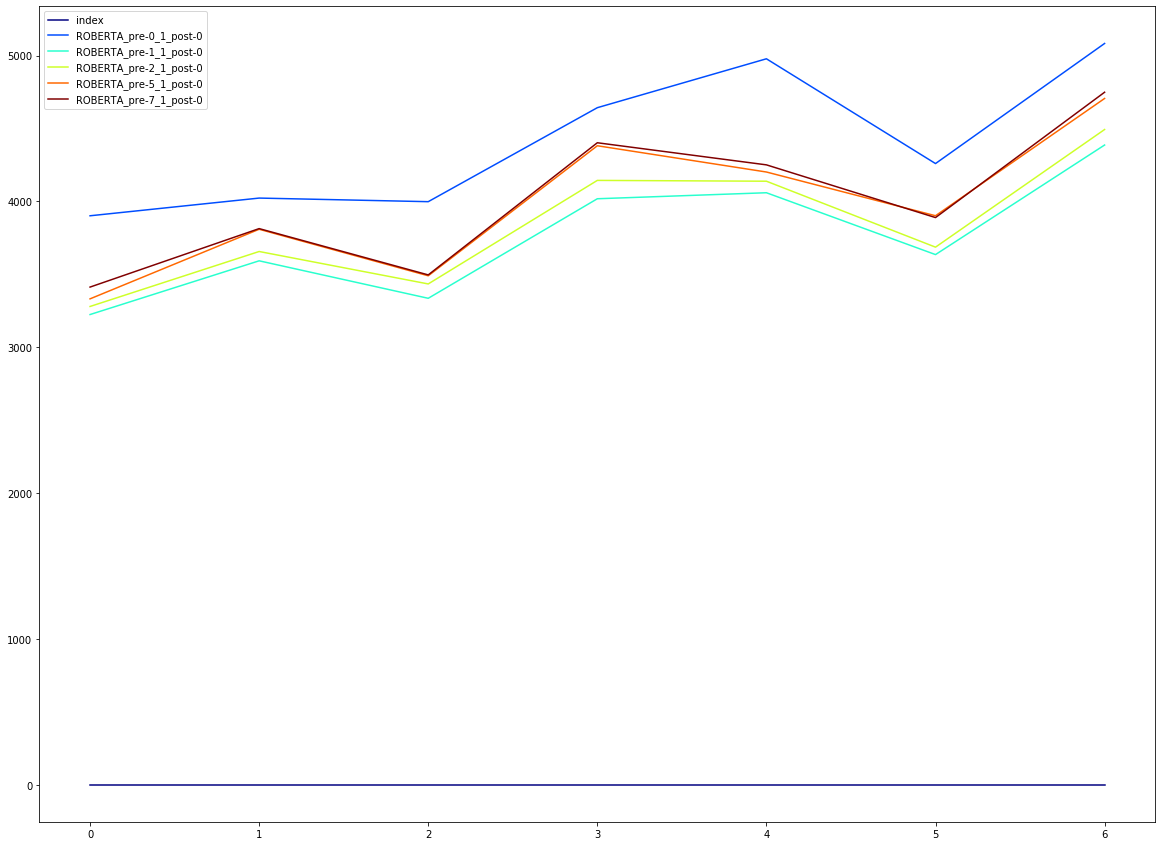

In [64]:

plt.figure()
all_results_roberta.plot(legend=True, colormap='jet', figsize=(20,15))
plt.legend(loc='best')

<Figure size 432x288 with 0 Axes>

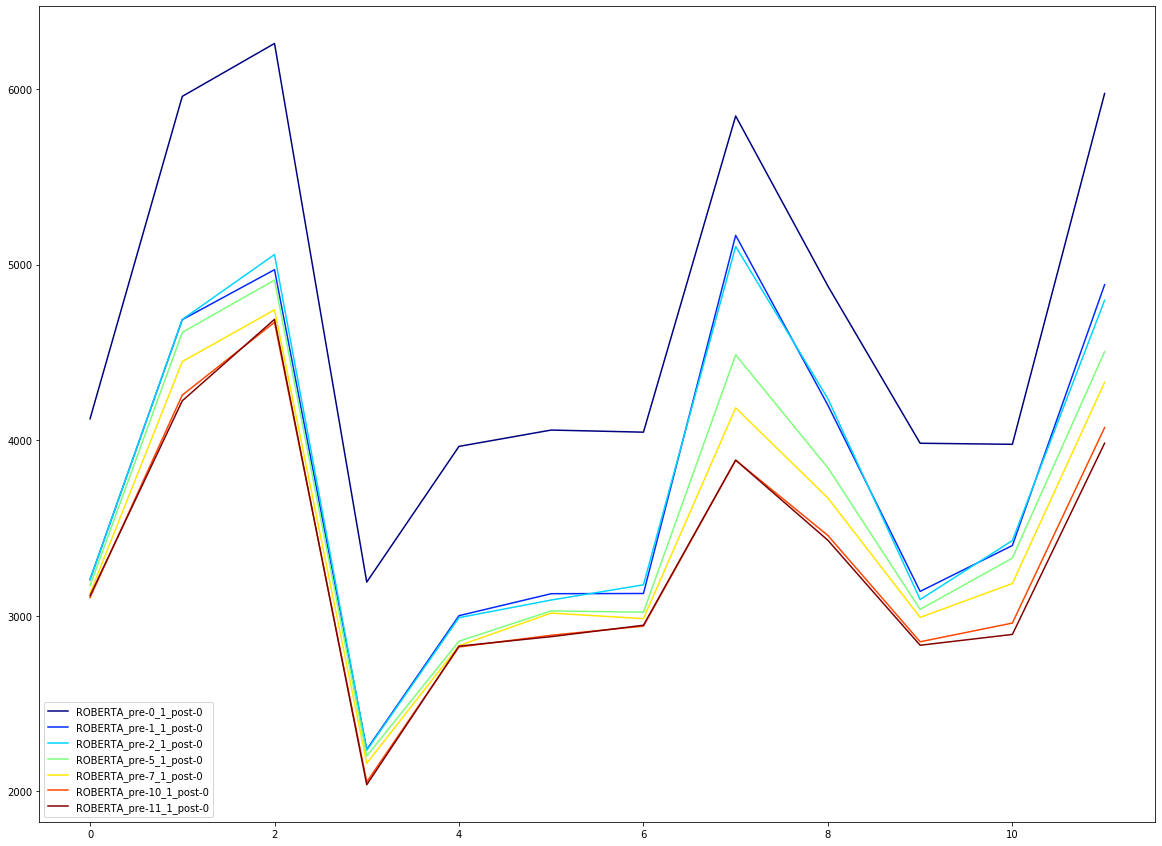

In [26]:
plt.figure()
all_results[['ROBERTA_pre-0_1_post-0', 
         'ROBERTA_pre-1_1_post-0', 
         'ROBERTA_pre-2_1_post-0', 
         'ROBERTA_pre-5_1_post-0', 
         'ROBERTA_pre-7_1_post-0', 
         'ROBERTA_pre-10_1_post-0', 
         'ROBERTA_pre-11_1_post-0',
         #'ROBERTA_pre-10_1_post-1',
         #'ROBERTA_pre-10_1_post-2',
         #'ROBERTA_pre-10_1_post-5',
         #'ROBERTA_pre-10_1_post-7',
         #'ROBERTA_pre-10_1_post-10',
        ]].plot(legend=True, colormap='jet', figsize=(20,15))
plt.legend(loc='best')

<Figure size 432x288 with 0 Axes>

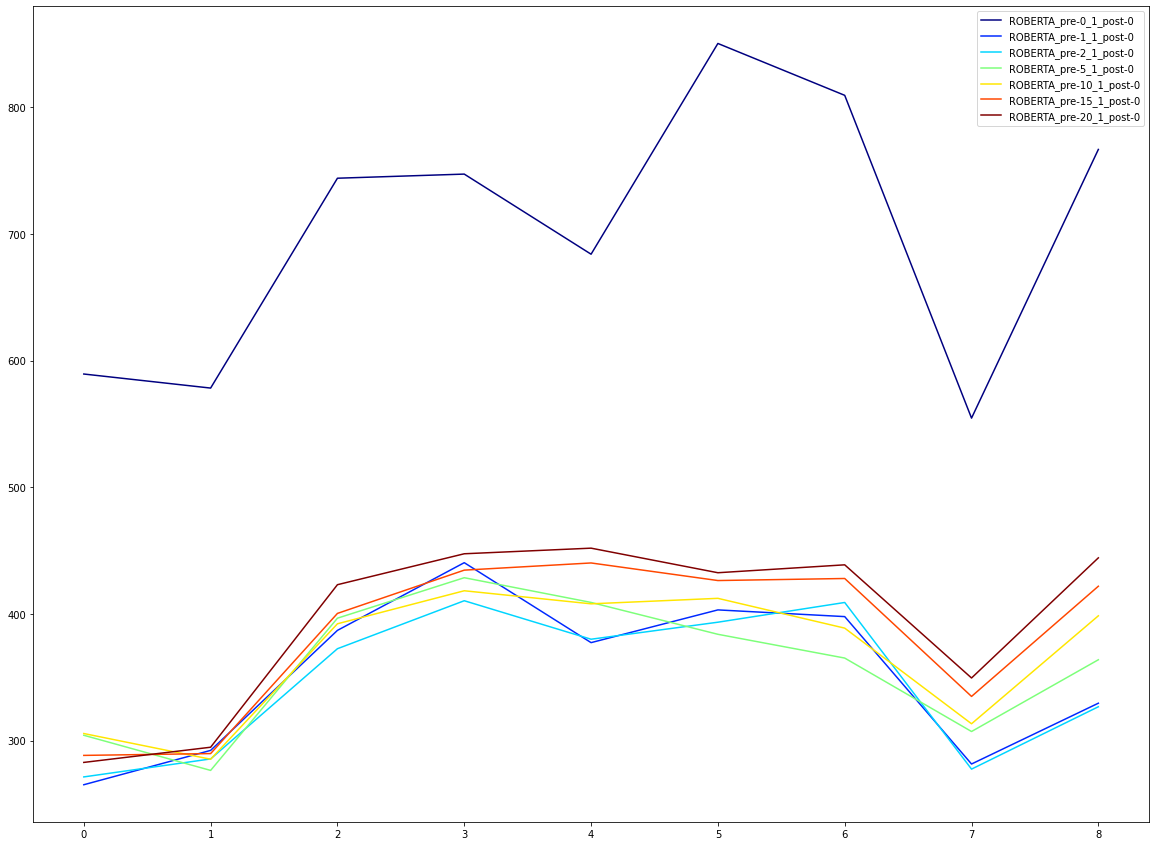

In [26]:
plt.figure()
results[['ROBERTA_pre-0_1_post-0', 
         'ROBERTA_pre-1_1_post-0', 
         'ROBERTA_pre-2_1_post-0', 
         'ROBERTA_pre-5_1_post-0', 
         'ROBERTA_pre-10_1_post-0', 
         'ROBERTA_pre-15_1_post-0',
         'ROBERTA_pre-20_1_post-0',
         #'ROBERTA_pre-10_1_post-1',
         #'ROBERTA_pre-10_1_post-2',
         #'ROBERTA_pre-10_1_post-5',
         #'ROBERTA_pre-10_1_post-7',
         #'ROBERTA_pre-10_1_post-10',
        ]].plot(legend=True, colormap='jet', figsize=(20,15))
plt.legend(loc='best')

<Figure size 432x288 with 0 Axes>

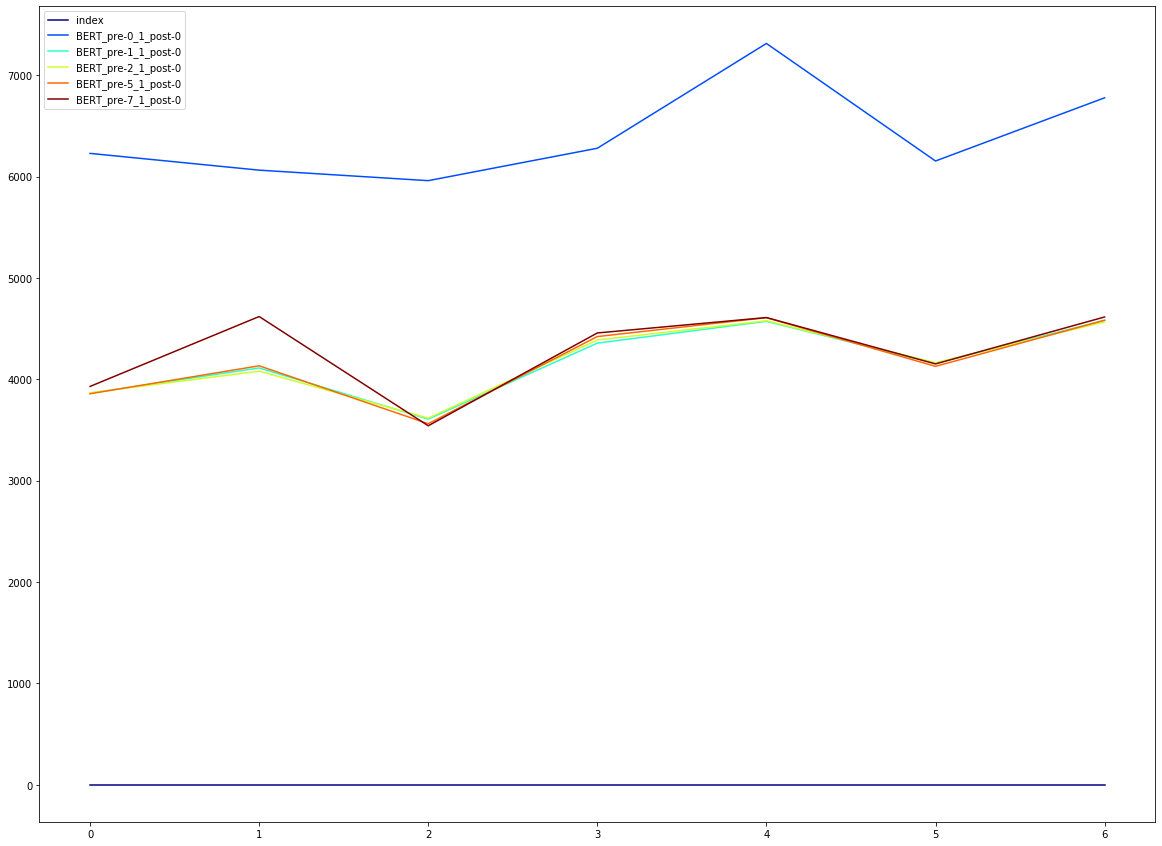

In [56]:

plt.figure()
all_results_bert.plot(legend=True, colormap='jet', figsize=(20,15))
plt.legend(loc='best')

<Figure size 432x288 with 0 Axes>

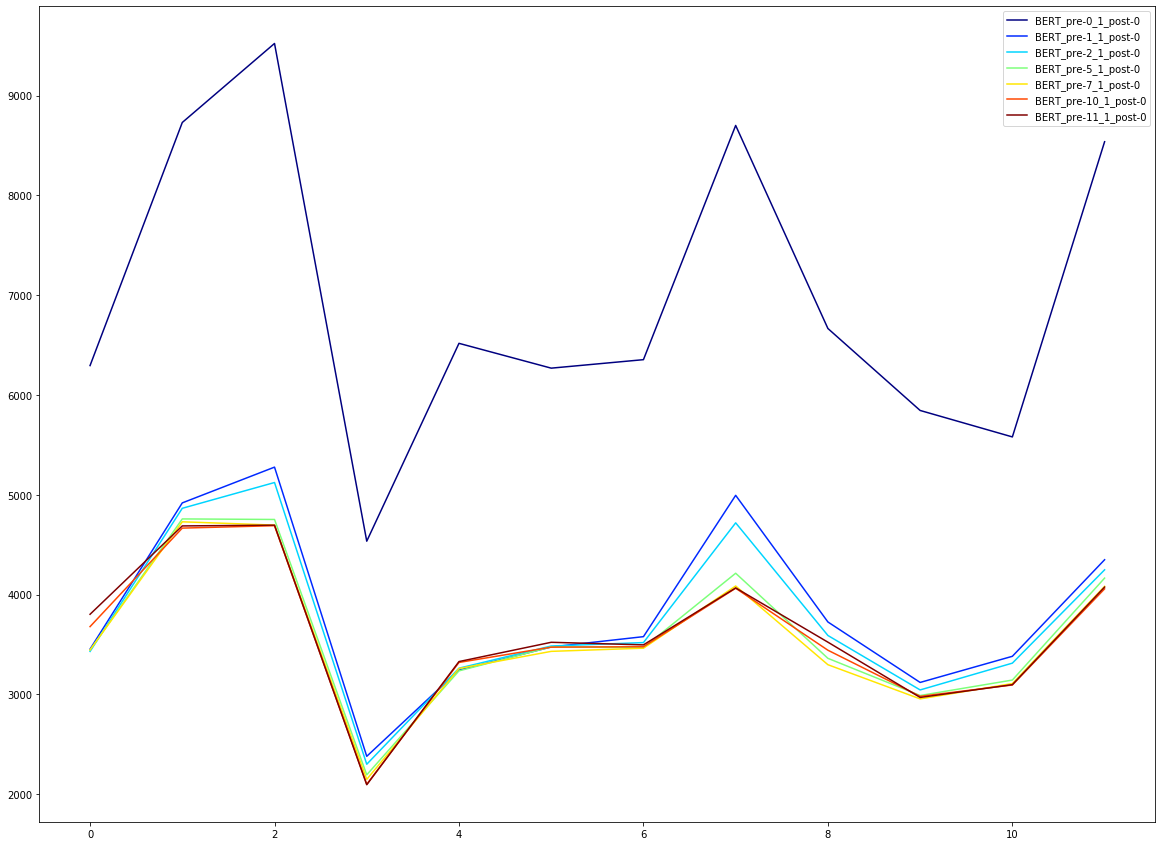

In [27]:
plt.figure()
all_results[['BERT_pre-0_1_post-0', 
         'BERT_pre-1_1_post-0', 
         'BERT_pre-2_1_post-0', 
         'BERT_pre-5_1_post-0', 
         'BERT_pre-7_1_post-0', 
         'BERT_pre-10_1_post-0', 
         'BERT_pre-11_1_post-0',
         #'BERT_pre-10_1_post-1',
         #'BERT_pre-10_1_post-2',
         #'BERT_pre-10_1_post-5',
         #'BERT_pre-10_1_post-7',
         #'BERT_pre-10_1_post-10',
        ]].plot(legend=True, colormap='jet', figsize=(20,15))
plt.legend(loc='best')

<Figure size 432x288 with 0 Axes>

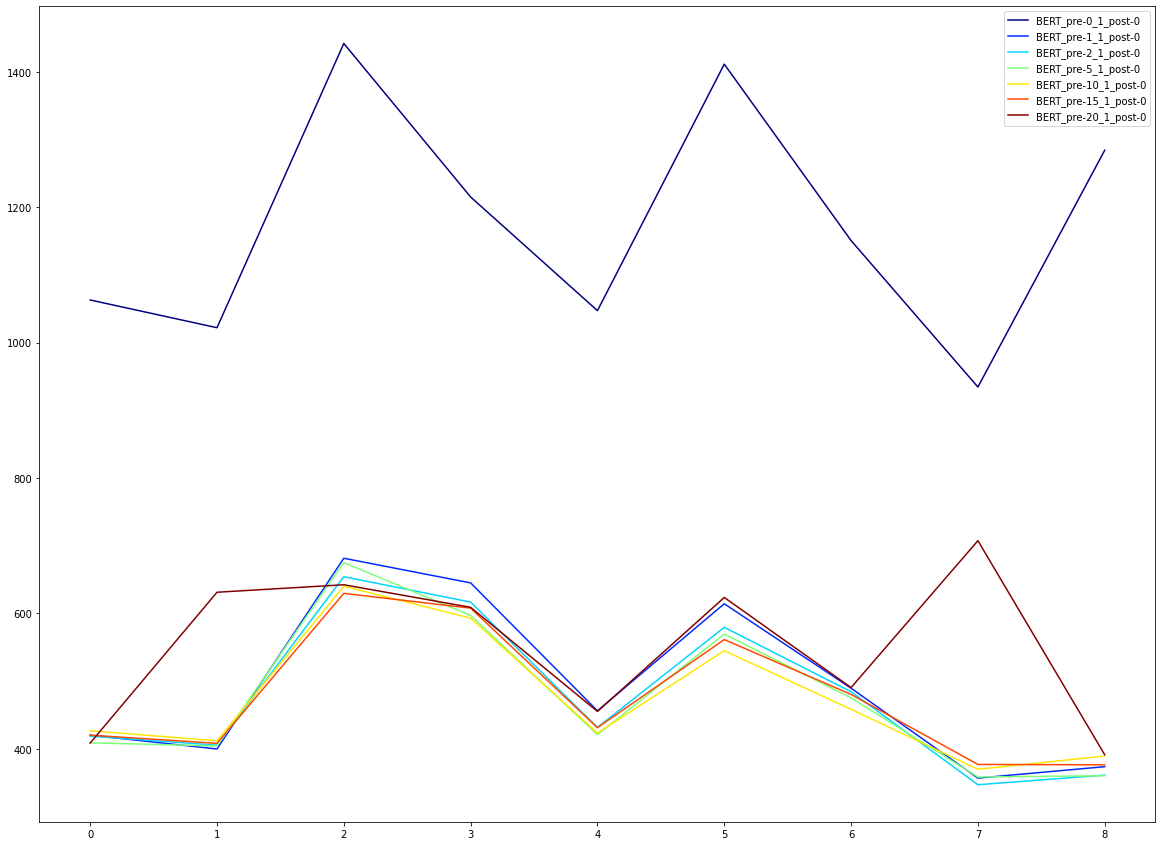

In [27]:
plt.figure()
results[['BERT_pre-0_1_post-0', 
         'BERT_pre-1_1_post-0', 
         'BERT_pre-2_1_post-0', 
         'BERT_pre-5_1_post-0', 
         'BERT_pre-10_1_post-0', 
         'BERT_pre-15_1_post-0',
         'BERT_pre-20_1_post-0',
         #'BERT_pre-10_1_post-1',
         #'BERT_pre-10_1_post-2',
         #'BERT_pre-10_1_post-5',
         #'BERT_pre-10_1_post-7',
         #'BERT_pre-10_1_post-10',
        ]].plot(legend=True, colormap='jet', figsize=(20,15))
plt.legend(loc='best')

<Figure size 432x288 with 0 Axes>

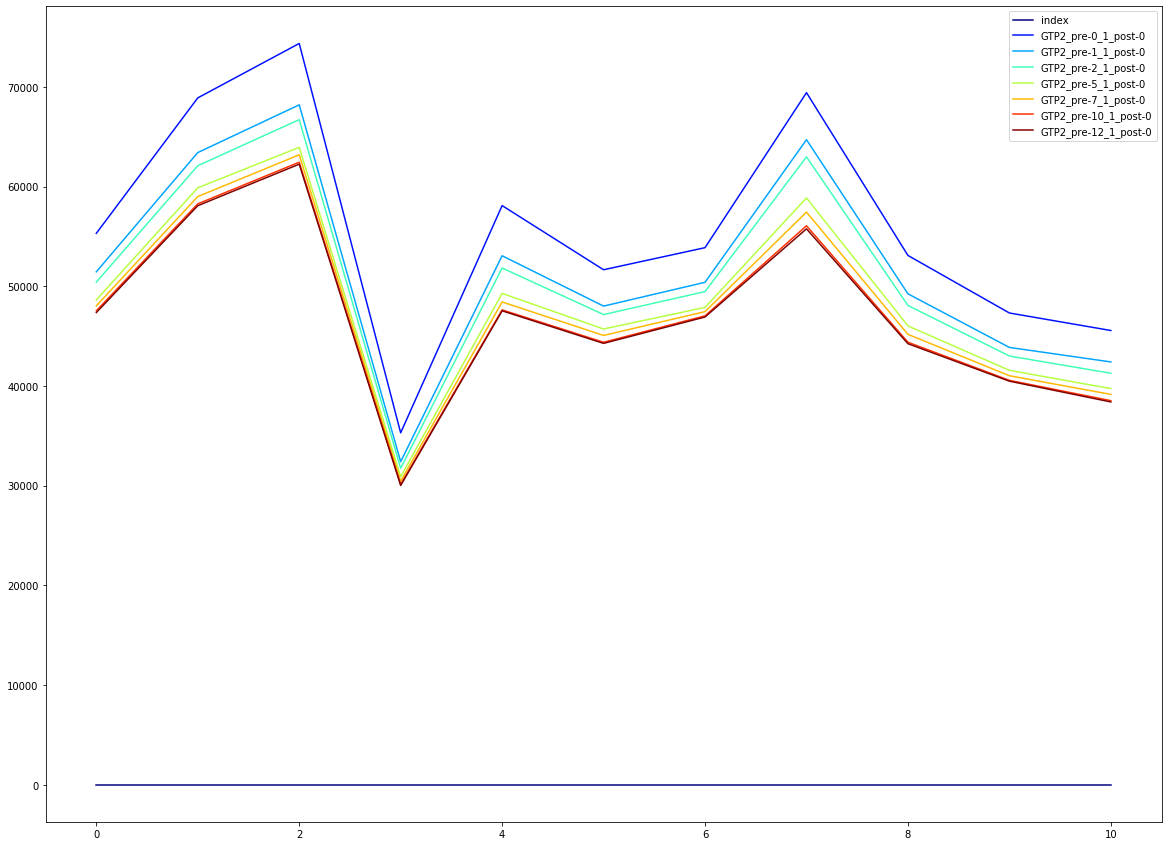

In [81]:
plt.figure()
all_results_gpt2.plot(legend=True, colormap='jet', figsize=(20,15))
plt.legend(loc='best')

<Figure size 432x288 with 0 Axes>

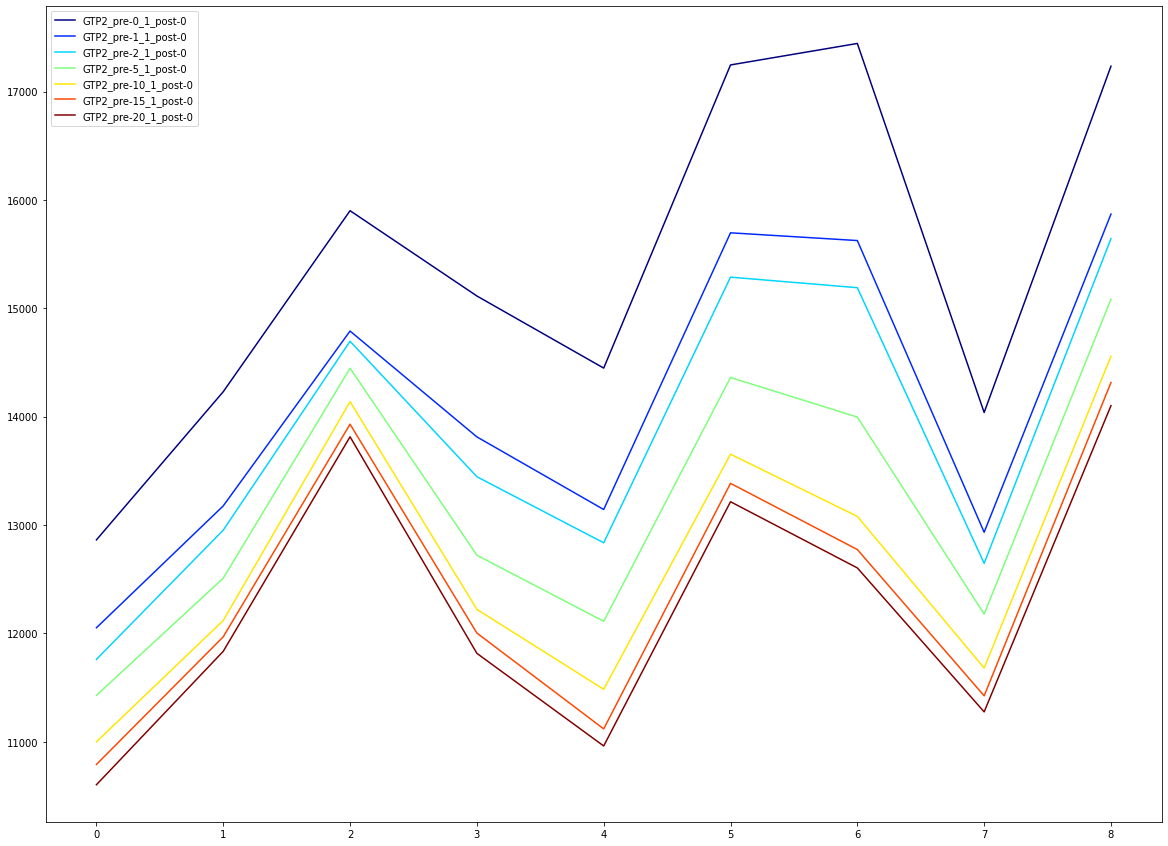

In [18]:
plt.figure()
results[['GTP2_pre-0_1_post-0', 
         'GTP2_pre-1_1_post-0', 
         'GTP2_pre-2_1_post-0', 
         'GTP2_pre-5_1_post-0', 
         'GTP2_pre-10_1_post-0', 
         'GTP2_pre-15_1_post-0',
         'GTP2_pre-20_1_post-0'
        ]].plot(legend=True, colormap='jet', figsize=(20,15))
plt.legend(loc='best')

In [22]:
results.sum()

index                            0.000000
GTP2_pre-0_1_post-0         138519.186087
GTP2_pre-1_1_post-0         127098.680981
GTP2_pre-2_1_post-0         124456.608247
GTP2_pre-5_1_post-0         118836.206902
GTP2_pre-10_1_post-0        113931.617376
GTP2_pre-15_1_post-0        111706.216393
GTP2_pre-20_1_post-0        110223.152238
BERT_pre-0_1_post-0          10570.803308
BERT_pre-1_1_post-0           4437.864272
BERT_pre-2_1_post-0           4299.505485
BERT_pre-5_1_post-0           4270.480832
BERT_pre-10_1_post-0          4258.406681
BERT_pre-15_1_post-0          4292.954585
BERT_pre-20_1_post-0          4960.033549
BERT_pre-10_1_post-1          3980.690856
BERT_pre-10_1_post-2          3963.189298
BERT_pre-10_1_post-5          3983.377918
BERT_pre-10_1_post-7          4018.862359
BERT_pre-10_1_post-10         4053.650858
ROBERTA_pre-0_1_post-0        6323.606747
ROBERTA_pre-1_1_post-0        3173.781378
ROBERTA_pre-2_1_post-0        3125.986635
ROBERTA_pre-5_1_post-0        3234

# Comparing perplexity with varying input sizes (transformers)

## BERT

In [184]:
from BERT.utils import batchify_per_sentence_with_pre_and_post_context as bert_batchify_per_sentence_with_pre_and_post_context
from BERT.utils import match_tokenized_to_untokenized as bert_match_tokenized_to_untokenized

In [180]:
pretrained_bert_model = 'bert-base-uncased'
bert_model = BertForMaskedLM.from_pretrained(pretrained_bert_model)
bert_tokenizer = BertTokenizer.from_pretrained(pretrained_bert_model)
iterator_list_bert = [[sent.lower() for sent in text] for text in iterator_list]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [279]:
def bert_set_config(number_of_sentence=1, number_of_sentence_before=2, number_of_sentence_after=0, max_length=512, stop_attention_before_sent=0, stop_attention_at_sent_before=None):
    config = {}
    config['number_of_sentence'] = number_of_sentence
    config['number_of_sentence_before'] = number_of_sentence_before
    config['number_of_sentence_after'] = number_of_sentence_after
    config['max_length'] = max_length
    config['stop_attention_before_sent'] = stop_attention_before_sent
    config['stop_attention_at_sent_before'] = stop_attention_at_sent_before
    return config

def bert_extract_activations_from_token_activations(activation, mapping, indexes, tokenized_text, average_spit_representation=True):
    """Take the average activations of the tokens related to a given word."""
    new_activations = []
    tokens = []
    key_start = None
    key_stop = None
    for key_, value in mapping.items(): 
        if (value[0] - 1)== (indexes[0]): #because we added [CLS] token at the beginning
            key_start = key_
    for key_, value in mapping.items(): 
        if value[-1] == (indexes[1]): #because we added [CLS] token at the beginning
            key_stop = key_
    for word_index in range(key_start, key_stop + 1): # len(mapping.keys()) - 1
        word_activation = []
        word_activation.append([activation[:,index, :] for index in mapping[word_index]])
        word_activation = np.vstack(word_activation)
        if average_spit_representation:
            new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
        else:
            new_activations.append(word_activation)
        tokens.append([tokenized_text[index] for index in mapping[word_index]])
    #print(' '.join([tokenizer.decode(tokenizer.convert_tokens_to_ids([tokenized_text[word] for word in mapping[index]])) for index in range(key_start, key_stop + 1)]))
    return new_activations, tokens

def compute_bert_entropy(activations, mapping, indexes, tokenized_text):
    extracted_activations, _ = bert_extract_activations_from_token_activations(activations, mapping, indexes, tokenized_text)
    pk = scipy.special.softmax(np.stack(extracted_activations, axis=0), axis=-1) # dim: #tokens_to_retrieve x #words_in_vocab
    entropy = scipy.stats.entropy(pk, axis=-1)
    return entropy.reshape(-1)
    
def compute_bert_surprisal(activations, mapping, indexes, tokenized_text):
    extracted_activations, tokens = bert_extract_activations_from_token_activations(activations, mapping, indexes, tokenized_text, average_spit_representation=False)
    surprisal = []
    for index_word, word in enumerate(tokens):
        tmp = []
        for index_token, token in enumerate(word):
            index_vocab = bert_tokenizer.convert_tokens_to_ids(token)
            tmp.append(scipy.special.softmax(extracted_activations[index_word], axis=-1)[index_token, 0, index_vocab])
        surprisal_word = 1-np.mean(tmp)
        surprisal.append(surprisal_word)
    return surprisal

def bert_process(model, model_name, iterator, tokenizer, config):
    entropy = []
    surprisal = []
    model.eval()
    batches, indexes = bert_batchify_per_sentence_with_pre_and_post_context(
                iterator, 
                config['number_of_sentence'], 
                config['number_of_sentence_before'], 
                config['number_of_sentence_after'], 
                model_name, 
                max_length=config['max_length'],
                stop_attention_before_sent=config['stop_attention_before_sent'],
                stop_attention_at_sent_before=config['stop_attention_at_sent_before']
            )
    indexes_tmp = []
    for i in range(len(indexes)):
        if type(indexes[i])==list and type(indexes[i][0])==list:
            indexes_tmp.append(indexes[i][-1])
        else:
            if i > 0:
                indexes_tmp.append((
                indexes[i][-config['number_of_sentence']-config['number_of_sentence_after']][0], 
                indexes[i][-config['number_of_sentence']-config['number_of_sentence_after']][1]))
            else:
                indexes_tmp.append(None)

    if config['number_of_sentence_before']==0:
        indexes_tmp[0] = (indexes[0][0][0][0], indexes[0][-1][1])
    else:
        indexes_tmp[0] = (indexes[0][0][0], indexes[0][-1][1])

    for index, batch in enumerate(batches):
        batch = batch.strip() # Remove trailing character
        batch = '[CLS] ' + batch + ' [SEP]'
        
        tokenized_text = tokenizer.wordpiece_tokenizer.tokenize(batch)
        mapping = bert_match_tokenized_to_untokenized(tokenized_text, batch)
        
        input_batch = []
        for i in range(indexes_tmp[index][0] + 1, indexes_tmp[index][1] + 1):
            tokenized_tmp = tokenizer.wordpiece_tokenizer.tokenize(batch)
            tokenized_tmp[i] = '[MASK]'        
            
            inputs_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_tmp)])
            input_batch.append(inputs_ids)
            
        inputs_ids =  torch.cat(input_batch, dim=0)
        
        with torch.no_grad():
            encoded_layers = model(inputs_ids) # last_hidden_state, pooler_output
            activations = encoded_layers[0].detach().numpy() # logits dimension: (batch_size, sequence_length, config.vocab_size)
            extracted_activations = []
            for index_batch, index_token in enumerate(range(indexes_tmp[index][0] + 1, indexes_tmp[index][1] + 1)):
                extracted_activations.append(activations[index_batch, index_token, :])
            extracted_activations = np.expand_dims(extracted_activations, axis=0)
            activations = np.concatenate([
                                np.zeros(
                                    (extracted_activations.shape[0], 
                                    indexes_tmp[index][0] + 1 , 
                                    extracted_activations.shape[-1]
                                    )), 
                                extracted_activations, 
                                np.zeros(
                                    (extracted_activations.shape[0], 
                                    len(tokenized_text) - indexes_tmp[index][1] - 1, 
                                    extracted_activations.shape[-1]
                                    ))

                                ], axis=1)
            entropy.append(compute_bert_entropy(activations, mapping, indexes_tmp[index], tokenized_text))
            surprisal.append(compute_bert_surprisal(activations, mapping, indexes_tmp[index], tokenized_text))
    
    return entropy, surprisal


In [280]:
# Test

#bert_config = bert_set_config(
#    number_of_sentence=1, 
#    number_of_sentence_before=2, 
#)
#
#bert_entropy, bert_surprisal = bert_process(
#                                bert_model, 
#                                'bert-base-uncased', 
#                                iterator_list_bert[0], 
#                                bert_tokenizer, 
#                                bert_config
#                            )
#entropy_run1 = np.hstack(gpt2_entropy)
#surprisal_run1 = np.hstack(gpt2_surprisal)

In [281]:
bert_models = [
    'bert_pre-2_1',
    'bert_pre-5_1',
    'bert_pre-7_1',
    'bert_pre-10_1',
    'bert_pre-15_1',
    'bert_pre-17_1',
    'bert_pre-20_1'
]
number_of_sentence_before_list = [2, 5, 7, 10, 15, 17, 20]
number_of_sentence = 1
bert_results = {'run{}'.format(i): {} for i in range(1, 10)}

In [282]:
for index_run, run in enumerate(iterator_list_bert):
    index_run += 1
    for index_model, model in tqdm(enumerate(bert_models)):
        bert_config = bert_set_config(
                            number_of_sentence=number_of_sentence, 
                            number_of_sentence_before=number_of_sentence_before_list[index_model], 
                        )

        bert_entropy, bert_surprisal = bert_process(
                                bert_model, 
                                'bert-base-uncased', 
                                run, 
                                bert_tokenizer, 
                                bert_config
                            )
        bert_results[f'run{index_run}'][model+'_entropy'] = bert_entropy
        bert_results[f'run{index_run}'][model+'_surprisal'] = bert_surprisal
        

7it [21:43, 186.20s/it]
7it [26:15, 225.08s/it]
7it [22:55, 196.54s/it]
7it [20:48, 178.31s/it]
7it [18:14, 156.40s/it]
7it [21:25, 183.70s/it]
7it [38:41, 331.68s/it]
7it [38:51, 333.01s/it]
7it [40:33, 347.69s/it]


In [283]:
save_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/other-analysis/perplexity'

In [284]:
bert_dataframes = [pd.DataFrame() for i in range(9)]
for index_run, run in enumerate(iterator_list_bert):
    for index_model, model in tqdm(enumerate(bert_models)):
        bert_dataframes[index_run][model+'_entropy'] = np.hstack(bert_results[f'run{index_run+1}'][model+'_entropy'])
        bert_dataframes[index_run][model+'_surprisal'] = np.hstack(bert_results[f'run{index_run+1}'][model+'_surprisal'])
    bert_dataframes[index_run].to_csv(os.path.join(save_folder, f'BERT_perplexity_run{index_run+1}.csv'), index=False)

7it [00:00, 505.62it/s]
7it [00:00, 583.68it/s]
7it [00:00, 476.52it/s]
7it [00:00, 526.85it/s]
7it [00:00, 530.25it/s]
7it [00:00, 466.85it/s]
7it [00:00, 514.40it/s]
7it [00:00, 588.60it/s]
7it [00:00, 504.00it/s]


<ipython-input-285-b3b3d5f4499e>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


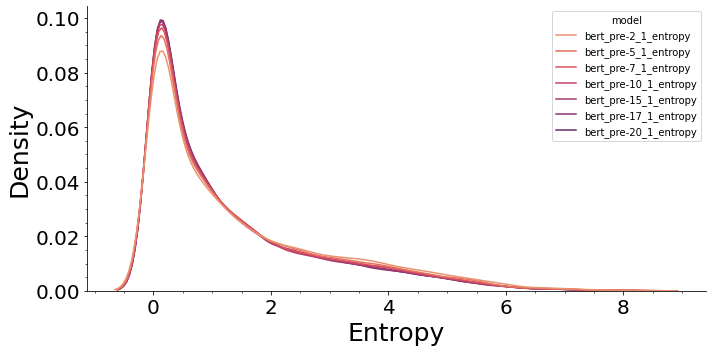

<ipython-input-285-b3b3d5f4499e>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


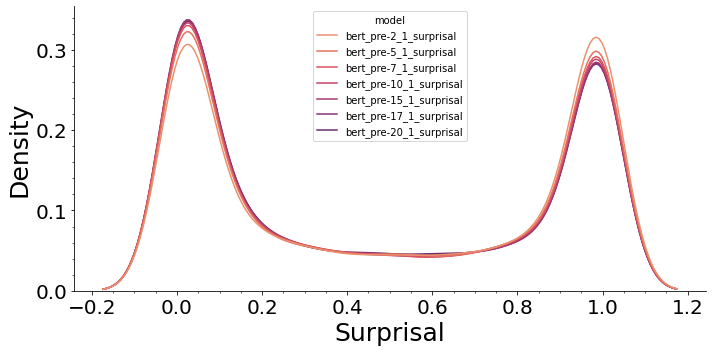

In [285]:
labelsize = 20
fontsize = 25
figsize = (10, 5)
format_figure = 'png'
ylabel = 'Density'
#X = np.linspace(-0.003, 0.2, 5)
rotation = 0


bert_id_surprisal = [col for col in bert_dataframes[0].columns if '_surprisal' in col]
bert_id_entropy = [col for col in bert_dataframes[0].columns if '_entropy' in col]


bert_df = pd.concat(bert_dataframes, axis=0)

bert_df_entropy = bert_df[bert_id_entropy]
bert_df_surprisal = bert_df[bert_id_surprisal]

bert_df_entropy = pd.melt(bert_df_entropy)
bert_df_surprisal = pd.melt(bert_df_surprisal)

bert_df_surprisal.columns = ['model', 'surprisal']
bert_df_entropy.columns = ['model', 'entropy']




plt.figure(figsize=figsize)
xlabel = 'Entropy'
sns.kdeplot(data=bert_df_entropy, x='entropy', hue='model', palette='flare')
plt.minorticks_on()
ax = plt.axes()
ax.tick_params(axis='x', labelsize=labelsize, rotation=rotation)
ax.tick_params(axis='y', labelsize=labelsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.xlabel(xlabel, fontsize=fontsize)
#plt.xticks(X, np.round(X, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
#plt.title('BERT - Entropy', fontsize=fontsize)
plt.savefig(os.path.join(save_folder, f'BERT_entropy.{format_figure}'), format=format_figure, dpi=400)
plt.show()

plt.figure(figsize=figsize)
xlabel = 'Surprisal'
sns.kdeplot(data=bert_df_surprisal, x='surprisal', hue='model', palette='flare')
plt.minorticks_on()
ax = plt.axes()
ax.tick_params(axis='x', labelsize=labelsize, rotation=rotation)
ax.tick_params(axis='y', labelsize=labelsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.xlabel(xlabel, fontsize=fontsize)
#plt.xticks(X, np.round(X, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
#plt.title('BERT - Surprisal', fontsize=fontsize)
plt.savefig(os.path.join(save_folder, f'BERT_surprisal.{format_figure}'), format=format_figure, dpi=400)
plt.show()

## GPT-2

In [177]:
from GPT2.utils import batchify_with_detailed_indexes as gpt2_batchify_with_detailed_indexes
from GPT2.utils import match_tokenized_to_untokenized as gpt2_match_tokenized_to_untokenized

In [12]:
pretrained_gpt2_model = 'gpt2'
gpt2_model = GPT2LMHeadModel.from_pretrained(pretrained_gpt2_model)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(pretrained_gpt2_model)
iterator_list_gpt2 = iterator_list.copy()

In [286]:
def gpt2_set_config(number_of_sentence=1, number_of_sentence_before=2, max_length=512, stop_attention_before_sent=0, stop_attention_at_sent=None):
    config = {}
    config['number_of_sentence'] = number_of_sentence
    config['number_of_sentence_before'] = number_of_sentence_before
    config['max_length'] = max_length
    config['stop_attention_before_sent'] = stop_attention_before_sent
    config['stop_attention_at_sent'] = stop_attention_at_sent
    return config

def gpt2_extract_activations_from_token_activations(activation, mapping, indexes, tokenized_text, average_spit_representation=True):
    """Take the average activations of the tokens related to a given word."""
    new_activations = []
    tokens = []
    key = None
    for key_, value in mapping.items(): 
        if indexes[0] in value:
            key = key_ 
    for word_index in range(key, len(mapping.keys()) - 2):
        word_activation = []
        word_activation.append([activation[:,index, :] for index in mapping[word_index]])
        word_activation = np.vstack(word_activation)
        if average_spit_representation:
            new_activations.append(np.mean(word_activation, axis=0).reshape(1,-1))
        else:
            new_activations.append(word_activation)
        tokens.append([tokenized_text[index+1] for index in mapping[word_index]]) #+1 as it is next word prediction
    return new_activations, tokens

def compute_gpt2_entropy(activations, mapping, indexes, tokenized_text):
    extracted_activations, _ = gpt2_extract_activations_from_token_activations(activations, mapping, indexes, tokenized_text)
    pk = scipy.special.softmax(np.stack(extracted_activations, axis=0), axis=-1) # dim: #tokens_to_retrieve x #words_in_vocab
    entropy = scipy.stats.entropy(pk, axis=-1)
    return entropy.reshape(-1)
    
def compute_gpt2_surprisal(activations, mapping, indexes, tokenized_text):
    extracted_activations, tokens = gpt2_extract_activations_from_token_activations(activations, mapping, indexes, tokenized_text, average_spit_representation=False)
    surprisal = []
    for index_word, word in enumerate(tokens):
        tmp = []
        for index_token, token in enumerate(word):
            index_vocab = gpt2_tokenizer.convert_tokens_to_ids(token)
            tmp.append(scipy.special.softmax(extracted_activations[index_word], axis=-1)[index_token, 0, index_vocab])
        surprisal_word = 1-np.mean(tmp)
        surprisal.append(surprisal_word)
    return surprisal

def gpt2_process(model, model_name, iterator, tokenizer, config, add_prefix_space=True):
    # Here, we give as input the batch of line by batch of line.
    entropy = []
    surprisal = []
    model.eval()
    batches, indexes = gpt2_batchify_with_detailed_indexes(
        iterator, 
        config['number_of_sentence'], 
        config['number_of_sentence_before'], 
        model_name, 
        max_length=config['max_length'],
        stop_attention_at_sent=config['stop_attention_at_sent'],
        stop_attention_before_sent=config['stop_attention_before_sent'],
        add_prefix_space=add_prefix_space
        )
    indexes_tmp = [(indexes[i][-config['number_of_sentence']][0], indexes[i][-1][1]) for i in range(len(indexes))]
    indexes_tmp[0] = (indexes[0][0][0], indexes[0][-1][1])
    
    for i in range(len(indexes_tmp)):
        indexes_tmp[i] = (indexes_tmp[i][0] + 1, indexes_tmp[i][1])

    for index, batch in enumerate(batches):
        batch = batch.strip() # Remove trailing character
        batch = '<|endoftext|> ' + batch + ' <|endoftext|>'

        tokenized_text = tokenizer.tokenize(batch, add_prefix_space=False)
        mapping = gpt2_match_tokenized_to_untokenized(tokenized_text, batch)
        inputs_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_text)])

        attention_mask = torch.tensor([[1 for x in tokenized_text]])

        with torch.no_grad():
            encoded_layers = model(inputs_ids, attention_mask=attention_mask) # last_hidden_state, pooler_output, 
            # logits dimension: (batch_size, sequence_length, config.vocab_size)
            activations = encoded_layers[0].detach().numpy()
            entropy.append(compute_gpt2_entropy(activations, mapping, indexes_tmp[index], tokenized_text))
            surprisal.append(compute_gpt2_surprisal(activations, mapping, indexes_tmp[index], tokenized_text))
    
    return entropy, surprisal


In [287]:
# Test

#gpt2_config = gpt2_set_config(
#    number_of_sentence=1, 
#    number_of_sentence_before=2, 
#)
#
#gpt2_entropy, gpt2_surprisal = gpt2_process(
#                                gpt2_model, 
#                                'gpt2', 
#                                iterator_list_gpt2[0], 
#                                gpt2_tokenizer, 
#                                gpt2_config, 
#                                add_prefix_space=True
#                            )
#entropy_run1 = np.hstack(gpt2_entropy)
#surprisal_run1 = np.hstack(gpt2_surprisal)

In [288]:
gpt2_models = [
    'gpt2_pre-2_1',
    'gpt2_pre-5_1',
    'gpt2_pre-7_1',
    'gpt2_pre-10_1',
    'gpt2_pre-15_1',
    'gpt2_pre-17_1',
    'gpt2_pre-20_1'
]
number_of_sentence_before_list = [2, 5, 7, 10, 15, 17, 20]
number_of_sentence = 1
gpt2_results = {'run{}'.format(i): {} for i in range(1, 10)}

In [289]:
for index_run, run in enumerate(iterator_list_gpt2):
    index_run += 1
    for index_model, model in tqdm(enumerate(gpt2_models)):
        gpt2_config = gpt2_set_config(
                            number_of_sentence=number_of_sentence, 
                            number_of_sentence_before=number_of_sentence_before_list[index_model], 
                        )

        gpt2_entropy, gpt2_surprisal = gpt2_process(
                                gpt2_model, 
                                'gpt2', 
                                run, 
                                gpt2_tokenizer, 
                                gpt2_config, 
                                add_prefix_space=True
                            )
        gpt2_results[f'run{index_run}'][model+'_entropy'] = gpt2_entropy
        gpt2_results[f'run{index_run}'][model+'_surprisal'] = gpt2_surprisal
        

7it [02:27, 21.09s/it]
7it [03:14, 27.83s/it]
7it [03:30, 30.13s/it]
7it [02:54, 24.94s/it]
7it [03:25, 29.33s/it]
7it [04:01, 34.47s/it]
7it [03:13, 27.65s/it]
7it [03:13, 27.58s/it]
7it [03:56, 33.78s/it]


In [290]:
save_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/other-analysis/perplexity'

In [291]:
gpt2_dataframes = [pd.DataFrame() for i in range(9)]
for index_run, run in enumerate(iterator_list_gpt2):
    for index_model, model in tqdm(enumerate(gpt2_models)):
        gpt2_dataframes[index_run][model+'_entropy'] = np.hstack(gpt2_results[f'run{index_run+1}'][model+'_entropy'])
        gpt2_dataframes[index_run][model+'_surprisal'] = np.hstack(gpt2_results[f'run{index_run+1}'][model+'_surprisal'])
    gpt2_dataframes[index_run].to_csv(os.path.join(save_folder, f'GPT-2_perplexity_run{index_run+1}.csv'), index=False)

7it [00:00, 307.53it/s]
7it [00:00, 335.97it/s]
7it [00:00, 433.65it/s]
7it [00:00, 565.67it/s]
7it [00:00, 625.75it/s]
7it [00:00, 595.33it/s]
7it [00:00, 241.15it/s]
7it [00:00, 290.12it/s]
7it [00:00, 256.76it/s]


<ipython-input-292-6a3b48ffa2f8>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


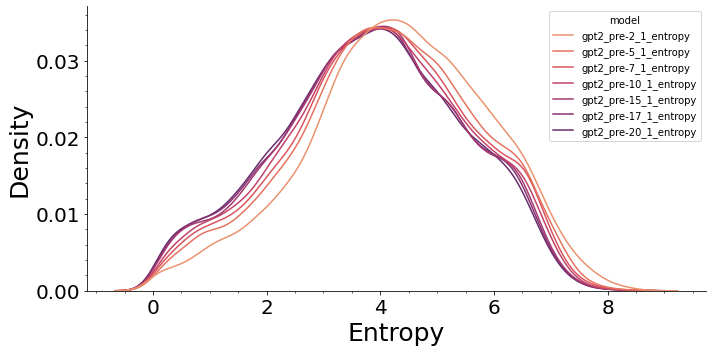

<ipython-input-292-6a3b48ffa2f8>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


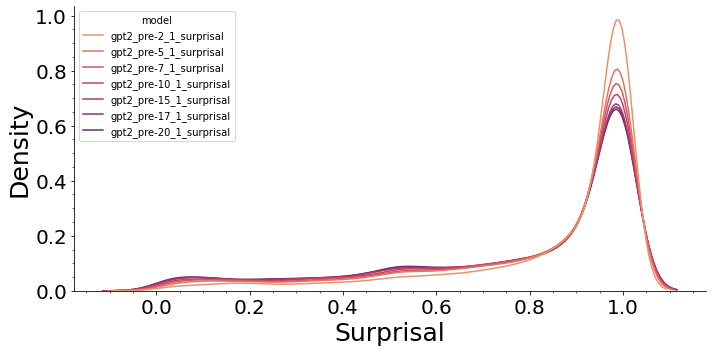

In [292]:
labelsize = 20
fontsize = 25
figsize = (10, 5)
format_figure = 'png'
ylabel = 'Density'
#X = np.linspace(-0.003, 0.2, 5)
rotation = 0


gpt2_id_surprisal = [col for col in gpt2_dataframes[0].columns if '_surprisal' in col]
gpt2_id_entropy = [col for col in gpt2_dataframes[0].columns if '_entropy' in col]


gpt2_df = pd.concat(gpt2_dataframes, axis=0)

gpt2_df_entropy = gpt2_df[gpt2_id_entropy]
gpt2_df_surprisal = gpt2_df[gpt2_id_surprisal]

gpt2_df_entropy = pd.melt(gpt2_df_entropy)
gpt2_df_surprisal = pd.melt(gpt2_df_surprisal)

gpt2_df_surprisal.columns = ['model', 'surprisal']
gpt2_df_entropy.columns = ['model', 'entropy']


plt.figure(figsize=figsize)
xlabel = 'Entropy'
sns.kdeplot(data=gpt2_df_entropy, x='entropy', hue='model', palette='flare')
plt.minorticks_on()
ax = plt.axes()
ax.tick_params(axis='x', labelsize=labelsize, rotation=rotation)
ax.tick_params(axis='y', labelsize=labelsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.xlabel(xlabel, fontsize=fontsize)
#plt.xticks(X, np.round(X, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
#plt.title('GPT-2 - Entropy', fontsize=fontsize)
plt.savefig(os.path.join(save_folder, f'GPT-2_entropy.{format_figure}'), format=format_figure, dpi=400)
plt.show()

plt.figure(figsize=figsize)
xlabel = 'Surprisal'
sns.kdeplot(data=gpt2_df_surprisal, x='surprisal', hue='model', palette='flare')
plt.minorticks_on()
ax = plt.axes()
ax.tick_params(axis='x', labelsize=labelsize, rotation=rotation)
ax.tick_params(axis='y', labelsize=labelsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.xlabel(xlabel, fontsize=fontsize)
#plt.xticks(X, np.round(X, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
#plt.title('GPT-2- Surprisal', fontsize=fontsize)
plt.savefig(os.path.join(save_folder, f'GPT-2_surprisal.{format_figure}'), format=format_figure, dpi=400)
plt.show()